<a href="https://colab.research.google.com/github/saxenabhishek/ConnectX/blob/main/ConnectX_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install kaggle-environments

In [24]:
# 1. Enable Internet in the Kernel (Settings side pane)

# 2. Curl cache may need purged if v0.1.6 cannot be found (uncomment if needed).
# !curl -X PURGE https://pypi.org/simple/kaggle-environments

# ConnectX environment was defined in v0.1.6
!pip -q install 'kaggle-environments'

# Create ConnectX Environment

In [ ]:
from kaggle_environments import evaluate, make, utils

env = make("connectx", debug=True)
env.render()

# Create an Agent

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim

In [173]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        # Not pythonic way of doing this
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        state = torch.tensor(state, dtype=torch.float32).float()
        action = torch.tensor(action)
        reward = torch.tensor(reward)
        next_state = torch.tensor(next_state, dtype=torch.float32).float()
        done = torch.tensor(done)

        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [104]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(np.prod(input_shape), 128)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.LeakyReLU()(self.fc1(x))
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x


In [138]:
class DQNAgent:
    def __init__(self,
                 input_shape,
                 num_actions,
                 learning_rate=0.001,
                 gamma=0.95,
                 epsilon=0.5,
                 epsilon_decay=0.995,
                 epsilon_min=0.01
            ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(input_shape, num_actions).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.num_actions = num_actions

    def choose_action(self, observation, configuration):
        if random.random() < self.epsilon:
            return random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])
        else:
            with torch.no_grad():
                state = torch.tensor(observation.board, dtype=torch.float).unsqueeze(0).to(self.device)
                q_values = self.model(state).cpu().numpy()[0]
                for c in range(configuration.columns):
                    if observation.board[c] != 0:
                        q_values[c] = -np.inf
                return int(np.argmax(q_values))

    def train(self, replay_buffer, batch_size=32):
        if len(replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        targets = rewards + torch.logical_not(dones).float() * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return self.epsilon


# Debug/Train your Agent

In [319]:
def mean_reward(rewards):
    return sum(rewards) / float(len(rewards))

In [314]:
input_shape = (6, 7) # shape of the board
num_actions = 7 # 7 columns to put coin in

agent = DQNAgent(input_shape, num_actions)
replay_buffer = ReplayBuffer(200)
batch_size = 32

reward_history = []


In [320]:
%%time

trainer = env.train([None, "negamax"])

total_episodes = 500

_r = [0]
observation = trainer.reset()

import tqdm
for episode in tqdm.notebook.tnrange(total_episodes):
    if episode % batch_size == 0:
        reward_history.append(mean_reward(_r))
        _r=[]

    done=False
    while not done:
        action = agent.choose_action(observation, env.configuration)
        new_observation, reward, done, info = trainer.step(action)

        replay_buffer.add(observation.board, action, reward, new_observation.board, done)
        observation = new_observation

        agent.train(replay_buffer, batch_size)

    _r.append(reward)
    trainer.reset()


  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 6min 55s, sys: 1.42 s, total: 6min 57s
Wall time: 7min 3s


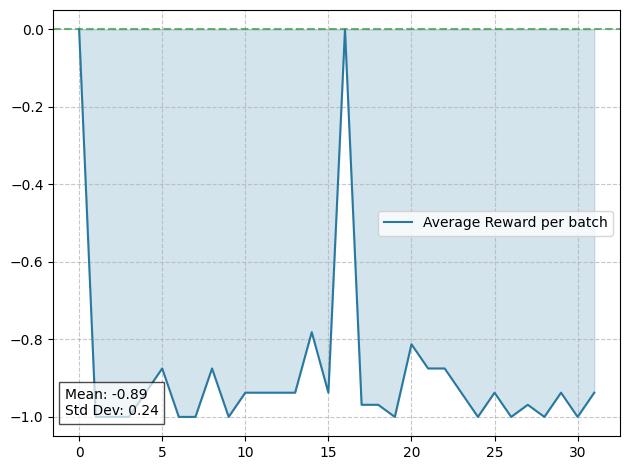

In [321]:
import seaborn as sns
import matplotlib.pyplot as plt
ax =sns.lineplot(reward_history, label='Average Reward per batch', linewidth=1.5,color='#2978A0')

plt.text(0.02, 0.05, f'Mean: {np.mean(reward_history):.2f}\nStd Dev: {np.std(reward_history):.2f}',
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

max_reward = max(reward_history)
plt.axhline(y=max_reward, color='#2E933C', linestyle='--', alpha=0.7,
            label=f'Max Reward: {max_reward:.2f}')

plt.fill_between(range(len(reward_history)), reward_history, alpha=0.2, color='#2978A0')


plt.grid(True, linestyle='--', alpha=0.7)

# Tighten layout and show the plot
plt.tight_layout()
plt.show()

# Evaluate your Agent

In [317]:
def reward_average(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", reward_average(evaluate("connectx", [agent.choose_action, "random"], num_episodes=100)))
print("My Agent vs Negamax Agent:", reward_average(evaluate("connectx", [agent.choose_action, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.72
My Agent vs Negamax Agent: -1.0


In [223]:
os.makedirs("submission", exist_ok=True)

In [303]:
torch.save(agent.model.state_dict(), "./submission/connect4_dqn.pth")

# Write Submission File



In [306]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "w" if os.path.exists(file) else "w") as f:
        f.write("""
import torch.nn as nn
import numpy as np
import torch
import sys
import os

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(np.prod(input_shape), 128)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.LeakyReLU()(self.fc1(x))
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x

input_shape = (6, 7)
num_actions = 7

cwd = '/kaggle_simulations/agent/'
if os.path.exists(cwd):
    sys.path.append(cwd)
else:
    cwd = ''

model = None


def inference(observation, configuration):
    global model

    board_tensor = torch.tensor(observation.board, dtype=torch.float32).unsqueeze(0)

    if model == None:
        model = DQN(input_shape, num_actions)
        model_path=cwd + "connect4_dqn.pth"
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()

    with torch.no_grad():
        q_values = model(board_tensor).cpu().numpy()[0]

    for c in range(configuration.columns):
        if observation.board[c] != 0:
            q_values[c] = -np.inf

    return int(np.argmax(q_values))
        """)
        print(function, "written to", file)

write_agent_to_file(DQN, "./submission/main.py")

<class '__main__.DQN'> written to ./submission/main.py


In [309]:
%%bash
tar -czfv submission.1.tar.gz -C submission .

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [298]:
import torch.nn as nn
import numpy as np
import torch
import sys

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(np.prod(input_shape), 128)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.LeakyReLU()(self.fc1(x))
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x

input_shape = (6, 7)
num_actions = 7

cwd = '/kaggle_simulations/agent/'
if os.path.exists(cwd):
    sys.path.append(cwd)
else:
    cwd = './submission/'

model = None


def inference(observation, configuration):
    global model

    board_tensor = torch.tensor(observation.board, dtype=torch.float32).unsqueeze(0)

    if model == None:
        model = DQN(input_shape, num_actions)
        model_path=cwd + "connect4_dqn.pth"
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()

    with torch.no_grad():
        q_values = model(board_tensor).cpu().numpy()[0]

    for c in range(configuration.columns):
        if observation.board[c] != 0:
            q_values[c] = -np.inf

    return int(np.argmax(q_values))

In [324]:
# Note: Stdout replacement is a temporary workaround.
# import sys
# out = sys.stdout
# submission = utils.read_file("/content/submission.py")
# agent = utils.get_last_callable(submission)
# sys.stdout = out

env = make("connectx", debug=True)
env.run([inference, "negamax"])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")
env.render(mode="ipython")

Success!


# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.